# Warning !!! your must decompress file, projects_file.tar.gz, before runing the entire script

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from genetic_selection import GeneticSelectionCV
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# Dataset Preparation

##  Select ID of Hippocampus sample

In [86]:
column_sample = pd.read_csv("columns-samples.csv").query("structure_name == 'hippocampus (hippocampal formation)'")

In [3]:
label_df = pd.read_csv("Sample_info.csv")

In [5]:
mdf = pd.merge(column_sample,label_df,on="donor_id")

## Merge Label with RNA Dataset

In [6]:
#prepare dataframe
df = pd.read_csv("fpkm_table_normalized.csv").rename(columns={'gene_id \ rnaseq_profile_id': 'rnaseq_profile_id'}).transpose().reset_index()
df_2 = df.iloc[1:,:]
df_2.columns = df.iloc[0,:]
df_2["rnaseq_profile_id"] = df_2["rnaseq_profile_id"].astype(int)

/Users/yean/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
# Categorize Phenotype:  Dementia = 1, Not = 0
mdf_2 = mdf[["rnaseq_profile_id","act_demented"]]
mdf_2["cat"] = np.where(mdf_2["act_demented"] == "Dementia",1,0)
mdf_3 = mdf_2[["rnaseq_profile_id","cat"]]

/Users/yean/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
#merge
hippo_dataset = pd.merge(mdf_3,df_2,on="rnaseq_profile_id").drop(['rnaseq_profile_id'], axis=1)
hippo_dataset.to_csv("hippo.csv")

In [9]:
hippo_dataset.groupby(["cat"]).size()

cat
0    51
1    43
dtype: int64

# Function for Trainig Logistic Regression 

In [10]:
# define evaluation metric
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


def CV_log(feature,label,mode):

    X_train, X_test, y_train, y_test = train_test_split(feature,label,test_size=0.3, random_state=0,stratify = label)
    f = pd.DataFrame(y_train,columns=["value"])
    f["type"] = "y_train"
    f_ = pd.DataFrame(y_test,columns=["value"])
    f_["type"] = "y_test"
    pd.concat([f,f_]).groupby(['type','value']).size().reset_index().to_csv("big_split_log"+mode+".csv")


    res_all_cv = []
    hyp_set = []
    sample_keep = []
    
    for rs in range(100):

        hyp = {
            "penalty":["l1","l2"],
            "C": np.arange(0.01,100,0.1).tolist()}

        penal_ = random.choice(hyp['penalty'])
        C_ = random.choice(hyp['C'])

        skf = StratifiedKFold(n_splits=5)
        skf.get_n_splits(X_train, y_train)

        cnt = 0
        
        for train_index, test_index in skf.split(X_train,y_train):   

            #Keep sample
            x_s = pd.DataFrame(y_train[train_index],columns=["index"])
            x_s["type"] = "train"
            y_s = pd.DataFrame(y_train[test_index],columns=["index"])
            y_s["type"] = "test"
            als = pd.concat([x_s,y_s])
            als["fold"] = cnt
            als["hyp"] = rs

            sample_keep.append(als)


            # Training Dataset
            model =  LogisticRegression(random_state=0,solver="liblinear",penalty=penal_,C=C_,max_iter=50000).fit(X_train[train_index],y_train[train_index])    

            def sum_res(model,x,y,cnt,rs,types):

                obs_cv = y
                pred_cv = model.predict(x)
                auc_cv = roc_auc_score(obs_cv, model.predict_proba(x)[:, 1])
                auc_cv_ = pd.DataFrame([auc_cv],columns=["value"])
                auc_cv_["cat"] = "auc"

                def cal_eval (y_true,y_pred):
                    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
                    specificity = tn / (tn+fp)
                    sensitivity = tp / (tp+fn)
                    return [specificity,sensitivity]

                cv_score = cal_eval(obs_cv,pred_cv)

                cv_sen_spec = pd.DataFrame(cv_score,columns=["value"])
                cv_sen_spec["cat"] = ["specificity","sensitivity"]

                cdf = pd.concat([auc_cv_,cv_sen_spec])
                cdf["fold"] = cnt
                cdf["rs"] = rs
                cdf["type"] = types

                return cdf

            tr = sum_res(model,X_train[train_index],y_train[train_index],cnt,rs,"Training")
            val = sum_res(model,X_train[test_index],y_train[test_index],cnt,rs,"Validating")
            a = pd.concat([tr,val])

            res_all_cv.append(a)

            cnt = cnt +1

        #save hyper space
        import pickle
        with open("hyper_"+str(rs)+mode+".pickle", 'wb') as handle:
            pickle.dump(model.get_params(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        


    # Selecting Best Param     
    x = pd.concat(res_all_cv).groupby(['cat','rs','type']).agg({'value': 'mean'}).reset_index()
    best_cv_ = x.query("cat == 'auc'& type == 'Validating'").sort_values('value', ascending=False).drop_duplicates(['cat','rs']).iloc[0,1]
    best_performed_cv = x.query("rs == @best_cv_")
    params = pickle.load(open("hyper_"+str(best_cv_)+mode+".pickle", "rb"))

    # Predicting optimal model on Testing datasets

    lr = LogisticRegression(**params).fit(X_train,y_train)

    lr_r = sum_res(lr,X_test,y_test,"test",best_cv_,"Testing").drop('fold', axis=1)
    final_report = pd.concat([lr_r,x]).query("rs == @best_cv_")
    final_report["N"] = mode
    
    #Report Sample number
    pd.concat(sample_keep).to_csv("sample_fold_log_"+mode+".csv")
    
    # save the model to disk
    filename = "model_"+str(rs)+mode+".sav"
    pickle.dump(model, open(filename, 'wb'))
    
    return final_report

# Feature Selection Method Comparison

## Negative control : randomly select

In [11]:
rnd_x = np.array(hippo_dataset.drop(['cat'], axis=1).sample(1000, axis=1))
rnd_y = np.array(hippo_dataset["cat"])

In [12]:
ng_re = CV_log(rnd_x,rnd_y,"random")

KeyboardInterrupt: 

## Negative control: All gene

In [16]:
all_x = np.array(hippo_dataset.drop(['cat'], axis=1))
rnd_y = np.array(hippo_dataset["cat"])

In [17]:
all_re = CV_log(all_x,rnd_y,"Enter")

## PCA

In [18]:
from sklearn.decomposition import PCA
rnd_x = np.array(hippo_dataset.drop(['cat'], axis=1))
rnd_y = np.array(hippo_dataset["cat"])
pca = PCA(n_components=10)
pc_x = pca.fit_transform(rnd_x)

In [19]:
pca_rs = CV_log(pc_x,rnd_y,"PCA")

## WGCNA

In [20]:
#WGCNA 1st variant 
wgcna_ = pd.read_csv("best_gene.csv").iloc[:,2].tolist()
wgcna_x = np.array(hippo_dataset[wgcna_])
rnd_y = np.array(hippo_dataset["cat"])
wgcna_rs = CV_log(wgcna_x,rnd_y,"WGCNA_yean")

In [22]:
#WGCNA 2nd variant 
f = pd.read_csv("mig.csv")["gene_id"].tolist()
wgcna_ = pd.read_csv("mig.csv")["gene_id"].tolist()
wgcna_migo = np.array(hippo_dataset[wgcna_])
rnd_y = np.array(hippo_dataset["cat"])
migo = CV_log(wgcna_migo,rnd_y,"WGCNA_MIG")

In [25]:
#WGCNA 3rd variant 
f = pd.read_csv("mig_new.csv")["Gene"].tolist()
wgcna_ = [str(float(f[i])) for i in range(len(f))]
wgcna_ = pd.read_csv("mig_new.csv")["Gene"].tolist()
wgcna_mign = np.array(hippo_dataset[wgcna_])
rnd_y = np.array(hippo_dataset["cat"])
mign = CV_log(wgcna_mign,rnd_y,"MigN")

In [26]:
#WGCNA 4th variant 
blu = pd.read_csv("blue.csv")["Gene"].tolist()
wgcna_blue = np.array(hippo_dataset[blu])
rnd_y = np.array(hippo_dataset["cat"])
mig_bl = CV_log(wgcna_blue,rnd_y,"MigN_blue")

In [27]:
#WGCNA 5th variant 
pu = pd.read_csv("purple.csv")["Gene"].tolist()
wgcna_pu = np.array(hippo_dataset[pu])
rnd_y = np.array(hippo_dataset["cat"])
mig_pur = CV_log(wgcna_pu,rnd_y,"MigN_purple")

In [28]:
#WGCNA 6th variant 
ma = pd.read_csv("magent.csv")["Gene"].tolist()
wgcna_ma = np.array(hippo_dataset[ma])
rnd_y = np.array(hippo_dataset["cat"])
mig_mag = CV_log(wgcna_ma,rnd_y,"MigN_Magent")

## Genetic Algorithm+WGCNA

In [32]:
wgcna_y = pd.read_csv("best_gene.csv").iloc[:,2].tolist()
wgcna_m = pd.read_csv("mig.csv")["gene_id"].tolist()

133

In [34]:
def GA_run(wgcna_,DF_S):
    all_ga = hippo_dataset[wgcna_]
    rnd_y = np.array(hippo_dataset["cat"])
    def ga_vote(round_,X_args):
        print(round_)
        estimator = LogisticRegression(max_iter=50000)
        model = GeneticSelectionCV(
            estimator, cv=StratifiedKFold(n_splits=2, shuffle=True), verbose=1,
            scoring="roc_auc",n_population=500, crossover_proba=0.9,
            mutation_proba=0.01, n_generations=100,caching=True, n_jobs=-1)
        model_ = model.fit(X_args, rnd_y)
        selected_f = X_args.columns[model_.support_].to_frame()
        selected_f["round"] = round_
        return selected_f
    vga = pd.concat([ga_vote(n,all_ga) for n in range(1)]).iloc[:,0].tolist()
    
    #save hyper space
    import pickle
    with open("variable"+DF_S+".pickle", 'wb') as handle:
        pickle.dump(vga, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
    ga_f = np.array(all_ga[vga])
    rnd_y = np.array(hippo_dataset["cat"])
    rga = CV_log(ga_f,rnd_y,DF_S)
    return rga

In [35]:
bga = GA_run(wgcna_y,"bg_GA")

0
Selecting features with genetic algorithm.
gen	nevals	avg                    	std                    	min                    	max                      
0  	500   	[0.63181098 8.182     ]	[0.06555774 4.26577965]	[0.38524143 1.        ]	[ 0.74734932 15.        ]
1  	446   	[-19.34602877   5.912     ]	[446.79543757   3.65243152]	[-10000.      0.]      	[ 0.75000999 15.        ]
2  	449   	[-39.32943554   4.308     ]	[631.23185093   2.58246704]	[-10000.      0.]      	[ 0.75466866 14.        ]
3  	438   	[-39.30713995   3.2       ]	[631.23326306   1.67809416]	[-10000.      0.]      	[ 0.7556044 10.       ]  
4  	453   	[-99.30668505   2.83      ]	[995.05711897   1.39610172]	[-10000.      0.]      	[ 0.75981685 10.        ]
5  	439   	[-39.28759514   2.362     ]	[631.23450156   1.13267648]	[-10000.      0.]      	[0.76661339 6.        ]  
6  	460   	[-39.28010687   1.87      ]	[631.23497703   0.8950419 ]	[-10000.      0.]      	[0.76661339 5.        ]  
7  	434   	[0.71768394 1.524     ] 

68 	441   	[0.72514428 1.022     ]    	[0.07162095 0.18307376]        	[0.4287679 1.       ]  	[0.76661339 3.        ]  
69 	436   	[0.73727686 1.032     ]    	[0.04880175 0.23446961]        	[0.43062604 1.        ]	[0.76661339 5.        ]  
70 	440   	[0.72757512 1.012     ]    	[0.07290943 0.10888526]        	[0.4287679 1.       ]  	[0.76661339 2.        ]  
71 	457   	[0.72360808 1.012     ]    	[0.07447074 0.10888526]        	[0.43062604 1.        ]	[0.76661339 2.        ]  
72 	461   	[0.74303902 1.012     ]    	[0.00584031 0.10888526]        	[0.67398934 1.        ]	[0.76661339 2.        ]  
73 	456   	[0.73269996 1.014     ]    	[0.05393767 0.11749043]        	[0.4287679 1.       ]  	[0.76661339 2.        ]  
74 	454   	[0.73286312 1.008     ]    	[0.05448653 0.08908423]        	[0.4287679 1.       ]  	[0.76661339 2.        ]  
75 	457   	[0.71769502 1.014     ]    	[0.09107431 0.14766178]        	[0.42788545 1.        ]	[0.76661339 3.        ]  
76 	447   	[0.74229724 1.02     

In [36]:
mga = GA_run(wgcna_m,"mig_GA")

0
Selecting features with genetic algorithm.
gen	nevals	avg                      	std                      	min                    	max                        
0  	500   	[ 0.55426345 66.986     ]	[ 0.06480292 37.86737123]	[0.34691309 1.        ]	[  0.70536464 133.        ]
1  	446   	[ 0.57403265 65.762     ]	[ 0.0642516  32.04854686]	[0.38873127 4.        ]	[  0.74362637 132.        ]
2  	446   	[ 0.58049984 60.206     ]	[ 0.05819874 30.63056585]	[ 0.41160506 10.        ]	[  0.74362637 132.        ]
3  	451   	[ 0.58972135 57.29      ]	[ 0.05852687 28.24390023]	[ 0.42632368 14.        ]	[  0.74362637 126.        ]
4  	463   	[ 0.59258708 51.39      ]	[ 0.06085955 23.45817342]	[ 0.38960706 16.        ]	[  0.75271728 115.        ]
5  	432   	[ 0.6081989 44.398    ]  	[ 0.05764048 18.87759508]	[ 0.40257409 18.        ]	[  0.76734266 109.        ]
6  	452   	[ 0.61757975 41.742     ]	[ 0.05862399 15.36643862]	[ 0.4315318 17.       ]  	[  0.76734266 100.        ]
7  	470   	[ 0.62162192 4

69 	440   	[ 0.78912356 23.258     ]	[0.04581938 2.07061247]  	[ 0.62859474 17.        ]	[ 0.90867133 30.        ]  
70 	451   	[ 0.78314615 23.116     ]	[0.04896921 2.00163533]  	[ 0.63378954 17.        ]	[ 0.90867133 34.        ]  
71 	454   	[ 0.7877896 23.148    ]  	[0.04182348 1.97131834]  	[ 0.61591409 18.        ]	[ 0.90867133 33.        ]  
72 	442   	[ 0.79177423 23.18      ]	[0.04442253 1.86      ]  	[ 0.63642691 18.        ]	[ 0.90867133 30.        ]  
73 	464   	[ 0.79444833 23.13      ]	[0.04835997 1.74845646]  	[ 0.53852148 18.        ]	[ 0.90867133 29.        ]  
74 	440   	[ 0.79172165 22.886     ]	[0.041448   1.75641795]  	[ 0.59699634 19.        ]	[ 0.90867133 33.        ]  
75 	453   	[ 0.78826421 22.836     ]	[0.04667159 1.76553221]  	[ 0.61682318 18.        ]	[ 0.90867133 34.        ]  
76 	446   	[ 0.79005858 22.836     ]	[0.04429749 1.6950233 ]  	[ 0.62398934 19.        ]	[ 0.90867133 32.        ]  
77 	460   	[ 0.78804538 22.958     ]	[0.04790234 1.71120893]  	[

In [37]:
mig_bl = GA_run(blu,"migb_GA")
mig_purplr = GA_run(pu,"migp_GA")
mig_mag = GA_run(ma,"migmag_GA")

0
Selecting features with genetic algorithm.
gen	nevals	avg                      	std                      	min                  	max                      
0  	500   	[ 0.50876224 24.618     ]	[ 0.0638722  13.96395632]	[0.3376024 1.       ]	[ 0.69316683 48.        ]
1  	450   	[ 0.51567866 19.162     ]	[ 0.0699235  13.48049539]	[0.30031635 1.        ]	[ 0.69316683 47.        ]
2  	437   	[-19.45543967  14.046     ]	[446.79054153  11.35164675]	[-10000.      0.]      	[ 0.69896104 44.        ]
3  	455   	[-39.44596697   9.586     ]	[631.22446714   8.10349332]	[-10000.      0.]      	[ 0.70997003 43.        ]
4  	460   	[-19.43096206   7.        ]	[446.79163613   5.96556787]	[-10000.      0.]      	[ 0.70997003 39.        ]
5  	454   	[-59.42542044   5.37      ]	[772.31402677   4.0646156 ]	[-10000.      0.]      	[ 0.70997003 24.        ]
6  	463   	[-99.4059977   4.744    ]  	[995.04713805   3.33143573]	[-10000.      0.]      	[ 0.70997003 19.        ]
7  	456   	[-119.39484015    4.484 

68 	440   	[0.68063849 3.074     ]      	[0.04070408 0.32942981]      	[0.56766567 3.        ]	[0.74538462 7.        ]  
69 	447   	[0.67417709 3.058     ]      	[0.04440085 0.25027185]      	[0.5337629 3.       ]  	[0.74538462 5.        ]  
70 	454   	[0.66918899 3.1       ]      	[0.04344619 0.36055513]      	[0.49259407 3.        ]	[0.74538462 6.        ]  
71 	461   	[0.67735512 3.15      ]      	[0.03503084 0.37881394]      	[0.58492507 3.        ]	[0.74538462 6.        ]  
72 	442   	[0.68314589 3.176     ]      	[0.03279511 0.45279576]      	[0.55483849 3.        ]	[0.74538462 8.        ]  
73 	450   	[0.65972268 3.17      ]      	[0.06503041 0.48280431]      	[0.47887113 3.        ]	[0.74538462 9.        ]  
74 	453   	[0.66673824 3.154     ]      	[0.04422429 0.47569318]      	[0.51365634 2.        ]	[0.74538462 8.        ]  
75 	448   	[0.67480238 3.168     ]      	[0.03501527 0.3997199 ]      	[0.50311355 3.        ]	[0.74538462 6.        ]  
76 	449   	[0.67976334 3.17     

35 	448   	[0.69931952 4.92      ]    	[0.04273631 0.64621978]    	[0.52981352 3.        ]	[0.77451548 7.        ]  
36 	457   	[0.70438457 4.944     ]    	[0.03782379 0.6138925 ]    	[0.49331668 3.        ]	[0.77451548 7.        ]  
37 	441   	[0.69927853 5.004     ]    	[0.05335937 0.49797992]    	[0.52432567 3.        ]	[0.77451548 7.        ]  
38 	457   	[0.69284019 5.024     ]    	[0.05071328 0.48106548]    	[0.52738595 3.        ]	[0.77451548 7.        ]  
39 	462   	[0.69270936 5.074     ]    	[0.04246997 0.42488116]    	[0.52981352 3.        ]	[0.77451548 7.        ]  
40 	452   	[0.69346257 5.058     ]    	[0.04946854 0.42265352]    	[0.57586747 3.        ]	[0.77451548 6.        ]  
41 	452   	[0.71216793 5.046     ]    	[0.03680727 0.43345588]    	[0.52432567 3.        ]	[0.77451548 6.        ]  
42 	453   	[0.69868148 5.062     ]    	[0.04697877 0.44514717]    	[0.49331668 3.        ]	[0.77451548 8.        ]  
43 	465   	[0.70440806 5.034     ]    	[0.04174116 0.33592261]  

3  	466   	[ 0.5741638 12.476    ]    	[0.06251686 7.00524261]    	[0.32051615 1.        ]	[ 0.71424908 30.        ]
4  	456   	[ 0.59126904 10.872     ]  	[0.05630536 6.04182224]    	[0.38413253 1.        ]	[ 0.71424908 27.        ]
5  	455   	[-19.39888438  10.022     ]	[446.79307143   5.58189179]	[-10000.      0.]      	[ 0.73241092 25.        ]
6  	436   	[-19.39406785   9.122     ]	[446.79328746   4.93346896]	[-10000.      0.]      	[ 0.75728938 24.        ]
7  	447   	[0.61745938 7.818     ]    	[0.05737484 4.04189015]    	[0.40669331 1.        ]	[ 0.75728938 21.        ]
8  	453   	[0.61600282 7.65      ]    	[0.0605998  3.71099717]    	[0.35865801 1.        ]	[ 0.75728938 19.        ]
9  	440   	[0.62246156 7.266     ]    	[0.05815717 3.19487778]    	[0.41597736 1.        ]	[ 0.75728938 16.        ]
10 	440   	[0.62619124 6.798     ]    	[0.05517434 2.9713963 ]    	[0.39074925 1.        ]	[ 0.75728938 18.        ]
11 	444   	[0.62910938 6.362     ]    	[0.05620749 2.54616496]  

74 	452   	[0.67197947 5.14      ]    	[0.04723602 0.42      ]    	[0.55099567 4.        ]	[0.7744289 8.       ]    
75 	464   	[0.66772468 5.116     ]    	[0.04800826 0.4319074 ]    	[0.53374292 4.        ]	[0.7744289 8.       ]    
76 	457   	[0.66889062 5.136     ]    	[0.04728903 0.49950375]    	[0.54400266 4.        ]	[0.7744289 8.       ]    
77 	461   	[0.6784058 5.18     ]      	[0.04737235 0.48948953]    	[0.44056943 4.        ]	[0.7744289 8.       ]    
78 	455   	[0.67429713 5.148     ]    	[0.04424707 0.43138846]    	[0.51180486 4.        ]	[0.7744289 8.       ]    
79 	454   	[0.67675887 5.126     ]    	[0.04100179 0.43142091]    	[0.56478521 4.        ]	[ 0.7744289 10.       ]  
80 	438   	[0.67360904 5.102     ]    	[0.05187071 0.33999412]    	[0.54304029 4.        ]	[0.7744289 8.       ]    
81 	455   	[0.68245592 5.084     ]    	[0.03831128 0.29823481]    	[0.5539627 5.       ]  	[0.7744289 7.       ]    
82 	414   	[0.67513909 5.046     ]    	[0.04434896 0.27547051]  

# Result Summary

In [38]:
plt_ = pd.concat([mga,mig_cbine,mig_bl,mig_purplr,mig_mag,all_re,ng_re])

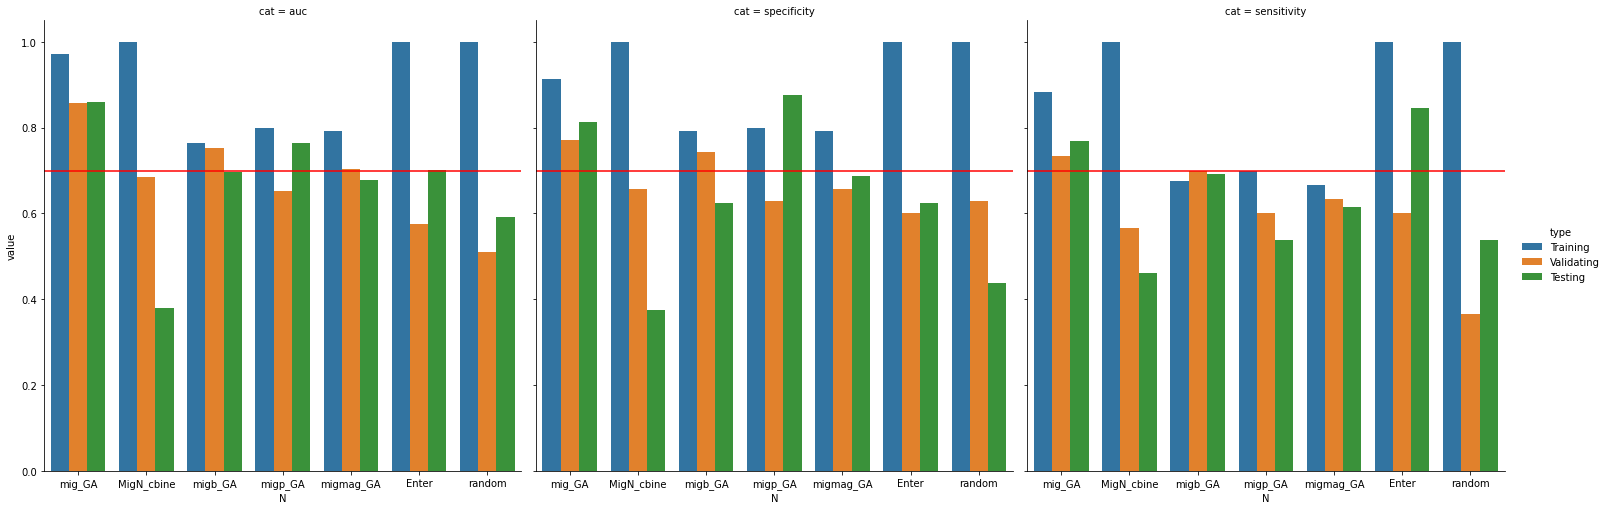

In [39]:
hue_order = ['Training', 'Validating', 'Testing']
g = sns.catplot(x="N", y="value", hue="type",col="cat",kind="bar",hue_order = hue_order,data=plt_,height=7)
ax1, ax2,ax3 = g.axes[0]
ax1.axhline(0.70,color="red")
ax2.axhline(0.70,color="red")
ax3.axhline(0.70,color="red")

## Confusion Matrix

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [87]:
GA_mig = pickle.load(open("variable"+"mig_GA"+".pickle", "rb"))
wgcna_x = np.array(hippo_dataset[GA_mig])
rnd_y = np.array(hippo_dataset["cat"])
feature = wgcna_x
label = rnd_y
X_train, X_test, y_train, y_test = train_test_split(feature,label,test_size=0.3, random_state=0,stratify = label)
params = pickle.load(open("hyper_"+"52"+"mig_GA"+".pickle", "rb"))
lr = LogisticRegression(**params).fit(X_train,y_train)
Pred_c = lr.predict(X_test)

FileNotFoundError: [Errno 2] No such file or directory: 'variablemig_GA.pickle'

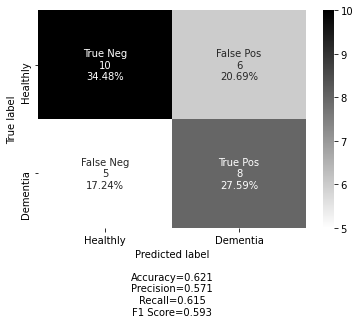

In [45]:
#Confusion matrix in testing dataset
cf = confusion_matrix(y_test,Pred_c)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Healthly","Dementia"]
make_confusion_matrix(cf,group_names=labels,
                      categories=categories, 
                      cmap="binary")


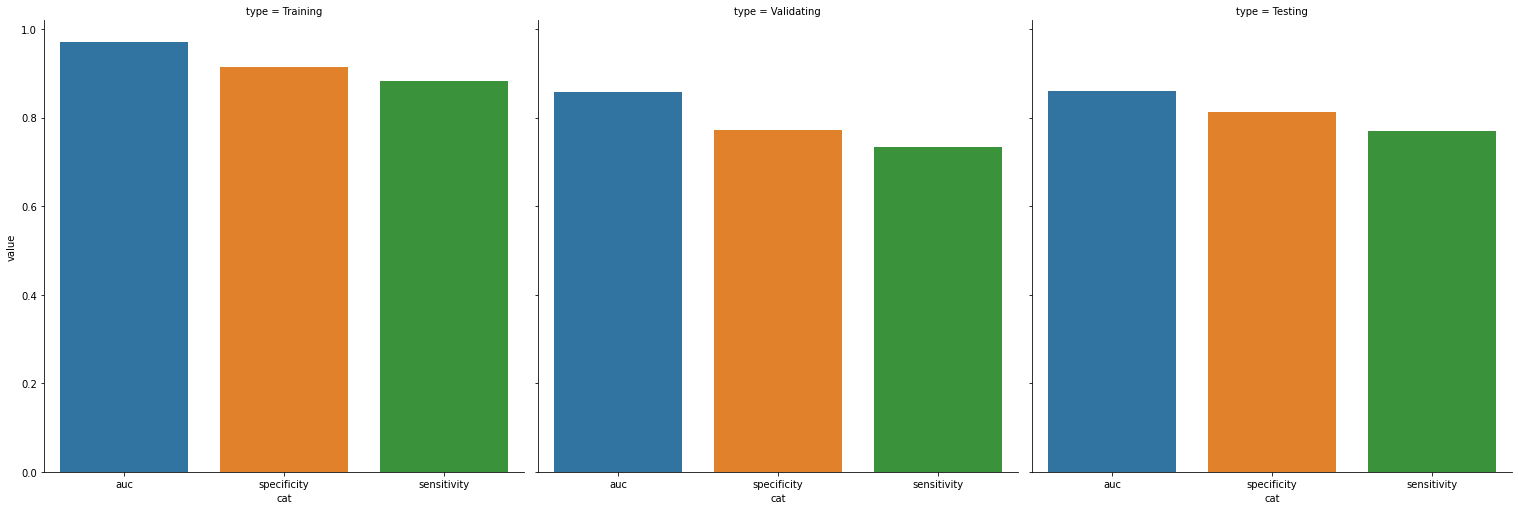

In [82]:
#all model performance of the optimal model
col_order = ['Training', 'Validating', 'Testing']
g = sns.catplot(x="cat", y="value",col="type",kind="bar",col_order = hue_order,data=mga,height=7)